In [1]:
# import and set options
import warnings
warnings.filterwarnings("ignore")
import matplotlib.style
import matplotlib as mpl
mpl.style.use('classic')
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import glob
import os
import scipy.stats as stats
import matplotlib as mpl
import utils
mpl.rcParams['pdf.fonttype'] = 42

## CASP8 correlation with Immune expression evidence

CASP8 mutations have previously been associated with leukocyte infiltration in tumors and IFN-y dominant immune subtype for tumors (PMID: 29628290). This has been suggested as an immune evasion mechanism. CASP8 has also been associated as a tumor suppressor gene (PMID: 29625053). Although clearly truncating/likely loss-of-function mutations, given its tumor suppressor gene role, would elicit an effect. It is not clear whether predictions by CHASMplus of rare driver missense mutations in CASP8 would have the same effect. CHASMplus found significant missense mutations in Head and Neck squamous cell carcinoma (HNSC), Bladder and Urothelial carcinoma (BLCA), Breast invasive carcinoma (BRCA), and Cervical Squamous Cell Carcinoma and Endocervical Adenocarcinoma (CESC).

In [2]:
# read in Immune information from the "The Immune Landscape of Cancer" (Thorsson et al., Immunity)
panimmune_df = pd.read_table('CHASMplus/data/misc/PanImmune_FeatureMatrix_20170526.tsv')

# CASP8 is the gene of interest
gene = 'CASP8'

# read mutation data
mut_df = pd.read_table('CHASMplus/data/aggregated_results/PANCAN.maf')

In [3]:
#######################
# Utility functions
########################

def identify_samples(mutations, gene, ctype):
    # read in CHASMplus results
    result_df = utils.read_result(ctype)
    is_signif = result_df[ctype]<=0.01
    is_gene = result_df['Hugo_Symbol'] == gene
    missense_variants = result_df[is_signif & is_gene]['HGVSp_Short'].unique()
    
    # figure out all of the samples
    all_samps = mutations['Tumor_Sample_Barcode'].unique()
    
    # parse samples
    is_driver_missense = (mutations['Hugo_Symbol']==gene) & (mutations['HGVSp_Short'].isin(missense_variants))
    inactivating_list = ['Nonsense_Mutation', 'Splice_Site', 'Frame_Shift_Del', 
                         'Frame_Shift_Ins', 'Nonstop_Mutation', 'Translation_Start_Site']
    is_inactivating = (mutations['Hugo_Symbol']==gene) & (mutations['Variant_Classification'].isin(inactivating_list))
    inactivating_samps = set(mutations[is_inactivating]['Tumor_Sample_Barcode'].str[:12].unique())
    missense_samps = set(mutations[is_driver_missense]['Tumor_Sample_Barcode'].str[:12].unique())
    mut_samps = set(inactivating_samps) | set(missense_samps)
    non_driver_mut_samps = set(mutations[mutations['Hugo_Symbol']==gene]['Tumor_Sample_Barcode'].str[:12].unique()) - set(mut_samps)
    wt_samps = list(set(all_samps) - (set(mut_samps) | set(non_driver_mut_samps)))
    
    # return samples
    return wt_samps, missense_samps, inactivating_samps

def mannwhitney_test(data):
    """Perform a mann-whitney u test on all columns of interest"""
    mycols = ['leukocyte_fraction', 'T.cells.CD8', 'T.cells.regulatory.Tregs', 
              'Th1.cells', 'Th17.cells', 'Th2.cells', 'CTLA4_RNASeq', 'CD8A_RNASeq', 
              'PDCD1_RNASeq', 'CD274_RNASeq', 'CD68_RNASeq', 'TREM1_RNASeq']
    output = [['variable', 'wt vs missense p-value', 'wt vs lof p-value', 'mis vs lof p-value']]
    cols_of_interest = [g.split('_RNASeq')[0] for g in mycols]
    for col in cols_of_interest:
        mis = data[data['driver status']=='mis'][col]
        lof = data[data['driver status']=='lof'][col]
        wt = data[data['driver status']=='control'][col]
        mis_pvalue = stats.mannwhitneyu(wt, mis).pvalue
        lof_pvalue = stats.mannwhitneyu(wt, lof).pvalue
        mis_lof_pvalue = stats.mannwhitneyu(mis, lof).pvalue
        output.append([col, mis_pvalue, lof_pvalue, mis_lof_pvalue])
    test_result_df = pd.DataFrame(output[1:], columns=output[0])
    return test_result_df


### Head & Neck


In [4]:
# cancer type
ctype = 'HNSC'

# cancer types with significant missense mutations in CASP8
ctype_immune_df = panimmune_df[panimmune_df['Study']==ctype].copy()

# figure out which samples contain driver mutations
wt_samps, missense_samps, inactivating_samps = identify_samples(mut_df[mut_df['CODE']==ctype], gene, ctype)

# label each sample
ctype_immune_df['driver status'] = 'control'
ctype_immune_df.loc[ctype_immune_df['ParticipantBarcode'].isin(missense_samps), 'driver status'] = 'mis'
ctype_immune_df.loc[ctype_immune_df['ParticipantBarcode'].isin(inactivating_samps), 'driver status'] = 'lof'
ctype_immune_df.loc[ctype_immune_df['ParticipantBarcode'].isin(wt_samps), 'driver status'] = 'control'

# prep input
genes = ['CTLA4_RNASeq', 'CD8A_RNASeq', 'PDCD1_RNASeq', 'CD274_RNASeq', 'CD68_RNASeq', 'TREM1_RNASeq']
for g in genes:
    ctype_immune_df[g.split('_')[0]] = np.log2(ctype_immune_df[g]+1)
genes = ['leukocyte_fraction', 'T.cells.CD8', 'T.cells.regulatory.Tregs', 
         'Th1.cells', 'Th17.cells', 'Th2.cells'] + genes
plot_df = pd.melt(ctype_immune_df, 
    id_vars=['ParticipantBarcode', 'Study', 'driver status',], 
    value_vars=[g.split('_RNASeq')[0] #if g!='leukocyte_fraction' else 'leukocyte_fraction' 
                for g in genes ],
    value_name='log2(RSEM+1)',
    var_name='var'
)

# rank test of differences
result_list = []
test_result_df = mannwhitney_test(ctype_immune_df)
test_result_df['cancer type'] = 'HNSC'
result_list.append(test_result_df)
test_result_df

,variable,wt vs missense p-value,wt vs lof p-value,mis vs lof p-value,cancer type
0,leukocyte_fraction,0.000067,0.000248,0.347542,HNSC
1,T.cells.CD8,0.000200,0.000276,0.150290,HNSC
2,T.cells.regulatory.Tregs,0.306188,0.309716,0.179689,HNSC
3,Th1.cells,0.000005,0.005064,0.013171,HNSC
4,Th17.cells,0.073618,0.180456,0.325538,HNSC
5,Th2.cells,0.352668,0.078705,0.213604,HNSC
6,CTLA4,0.001806,0.026692,0.097402,HNSC
7,CD8A,0.000026,0.003328,0.032941,HNSC
8,PDCD1,0.000066,0.017043,0.022749,HNSC
9,CD274,0.000024,0.000219,0.174975,HNSC


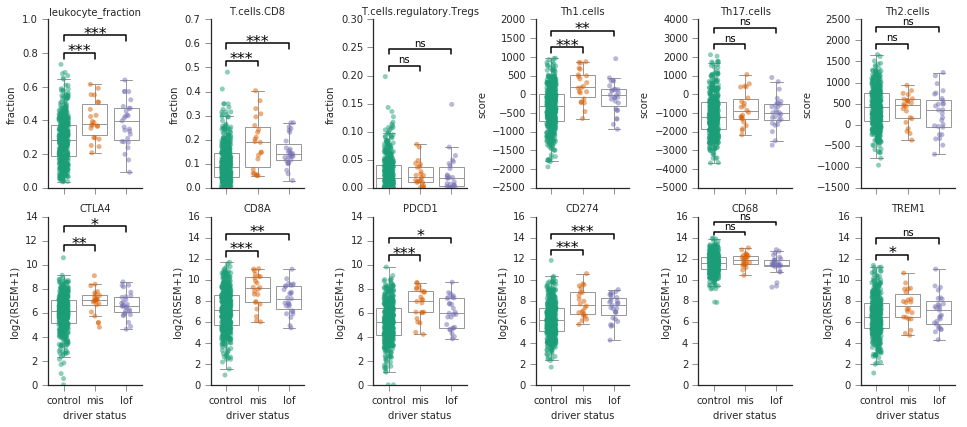

In [5]:
# plot data
myorder = ['control', 'mis', 'lof']
with sns.axes_style('ticks'):
    fg = sns.FacetGrid(plot_df, col='var', col_wrap=6,
                       aspect=.75, sharey=False,)
    fg.map(sns.boxplot, 'driver status', 'log2(RSEM+1)', color='white', order=myorder, fliersize=0)
    fg.map(sns.stripplot, 'driver status', 'log2(RSEM+1)', order=myorder, jitter=.15, palette="Dark2",  alpha=.5)
    fg.map(utils.box_plot_with_significance, 'driver status', 'log2(RSEM+1)', data=plot_df, signif=test_result_df)
    [a.set_ylim(0,) for ix, a in enumerate(fg.axes) if ix<3 or ix>5]
    [a.set_ylabel('log2(RSEM+1)') if ix>2 else a.set_ylabel('fraction')  
     for ix, a in enumerate(fg.axes)]
    [a.set_ylabel('score') 
     for ix, a in enumerate(fg.axes) if ix>2 and ix<6]
    fg.axes[0].set_ylabel('fraction')
    fg.set_titles("{col_name}")
    plt.tight_layout()
    plt.savefig('CHASMplus/figures/figure_4.pdf')

In [8]:
# save HNSC CASP8 drivers
is_casp8 = mut_df['Hugo_Symbol']=='CASP8'
is_driver = mut_df['Tumor_Sample_Barcode'].str[:12].isin(missense_samps | inactivating_samps)

# read in CHASMplus results
result_df = utils.read_result('HNSC')
is_signif = result_df[ctype]<=0.01
is_gene = result_df['Hugo_Symbol'] == gene
missense_variants = result_df[is_signif & is_gene]['HGVSp_Short'].unique()
is_missense_driver = mut_df['HGVSp_Short'].isin(missense_variants)

# flag likely inactivating mutations
inactivating_list = ['Nonsense_Mutation', 'Splice_Site', 'Frame_Shift_Del', 
                     'Frame_Shift_Ins', 'Nonstop_Mutation', 'Translation_Start_Site']
is_inactivating = (mut_df['Variant_Classification'].isin(inactivating_list))

# save results
casp8_mut_df = mut_df[is_casp8 & (is_missense_driver | is_inactivating) & (mut_df['CODE']=='HNSC')].copy()
casp8_mut_df['Strand'] = '+'
out_cols = ['Chromosome', 'Start_Position', 'Strand', 'Reference_Allele', 'Tumor_Seq_Allele2', 'Tumor_Sample_Barcode']
#casp8_mut_df[out_cols].to_csv('/Users/ctokheim/Downloads/hnsc_casp8.txt', sep='\t')
casp8_mut_df['Variant_Classification'].value_counts()

Missense_Mutation    26
Nonsense_Mutation    19
Splice_Site           5
Frame_Shift_Del       4
Frame_Shift_Ins       1
Name: Variant_Classification, dtype: int64

### Bladder carcinoma

In [9]:
# cancer type
ctype = 'BLCA'

# cancer types with significant missense mutations in CASP8
ctype_immune_df = panimmune_df[panimmune_df['Study']==ctype].copy()

# figure out which samples contain driver mutations
wt_samps, missense_samps, inactivating_samps = identify_samples(mut_df, gene, ctype)

# label each sample
ctype_immune_df['driver status'] = 'control'
ctype_immune_df.loc[ctype_immune_df['ParticipantBarcode'].isin(missense_samps), 'driver status'] = 'mis'
ctype_immune_df.loc[ctype_immune_df['ParticipantBarcode'].isin(inactivating_samps), 'driver status'] = 'lof'
ctype_immune_df.loc[ctype_immune_df['ParticipantBarcode'].isin(wt_samps), 'driver status'] = 'control'

# prep input
genes = ['CTLA4_RNASeq', 'CD8A_RNASeq', 'PDCD1_RNASeq', 'CD274_RNASeq', 'CD68_RNASeq', 'TREM1_RNASeq']
for g in genes:
    ctype_immune_df[g.split('_')[0]] = np.log2(ctype_immune_df[g]+1)
genes = ['leukocyte_fraction', 'T.cells.CD8', 'T.cells.regulatory.Tregs', 
         'Th1.cells', 'Th17.cells', 'Th2.cells'] + genes
plot_df = pd.melt(ctype_immune_df, 
    id_vars=['ParticipantBarcode', 'Study', 'driver status',], 
    value_vars=[g.split('_RNASeq')[0] #if g!='leukocyte_fraction' else 'leukocyte_fraction' 
                for g in genes ],
    value_name='log2(RSEM+1)',
    var_name='var'
)

# rank test of differences
test_result_df = mannwhitney_test(ctype_immune_df)
test_result_df['cancer type'] = 'BLCA'
result_list.append(test_result_df)
test_result_df

,variable,wt vs missense p-value,wt vs lof p-value,mis vs lof p-value,cancer type
0,leukocyte_fraction,0.046358,0.045024,0.185547,BLCA
1,T.cells.CD8,0.063159,0.395175,0.185547,BLCA
2,T.cells.regulatory.Tregs,0.367316,0.114436,0.500000,BLCA
3,Th1.cells,0.058076,0.149962,0.185547,BLCA
4,Th17.cells,0.498311,0.178911,0.500000,BLCA
5,Th2.cells,0.280898,0.101044,0.500000,BLCA
6,CTLA4,0.089725,0.065551,0.185547,BLCA
7,CD8A,0.055184,0.079664,0.185547,BLCA
8,PDCD1,0.058075,0.068720,0.185547,BLCA
9,CD274,0.132690,0.028715,0.500000,BLCA


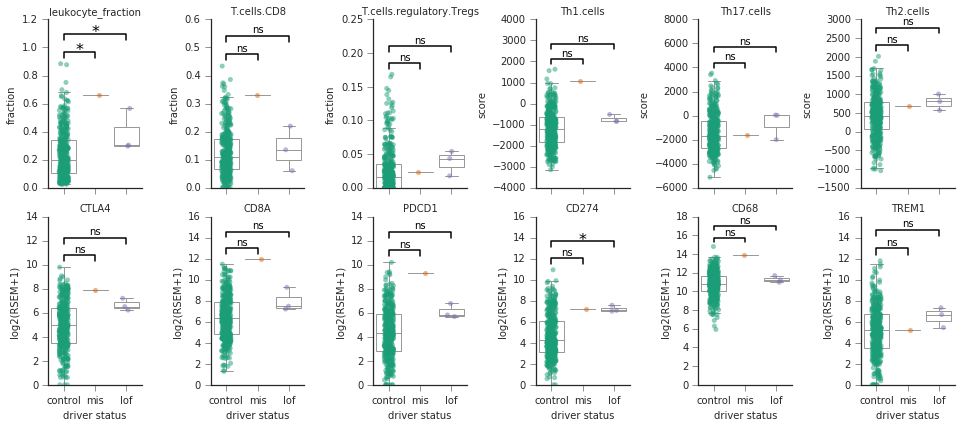

In [10]:
# plot data
myorder = ['control', 'mis', 'lof']
with sns.axes_style('ticks'):
    fg = sns.FacetGrid(plot_df, col='var', col_wrap=6,
                       aspect=.75, sharey=False,)
    fg.map(sns.boxplot, 'driver status', 'log2(RSEM+1)', color='white', order=myorder, fliersize=0)
    fg.map(sns.stripplot, 'driver status', 'log2(RSEM+1)', order=myorder, jitter=.15, palette="Dark2",  alpha=.5)
    fg.map(utils.box_plot_with_significance, 'driver status', 'log2(RSEM+1)', data=plot_df, signif=test_result_df)
    [a.set_ylim(0,) for ix, a in enumerate(fg.axes) if ix<3 or ix>5]
    [a.set_ylabel('log2(RSEM+1)') if ix>2 else a.set_ylabel('fraction')  
     for ix, a in enumerate(fg.axes)]
    [a.set_ylabel('score') 
     for ix, a in enumerate(fg.axes) if ix>2 and ix<6]
    fg.axes[0].set_ylabel('fraction')
    fg.set_titles("{col_name}")
    plt.tight_layout()
    plt.savefig('CHASMplus/figures/figure_S6b.pdf')

### Breast

In [11]:
# cancer type
ctype = 'BRCA'

# cancer types with significant missense mutations in CASP8
ctype_immune_df = panimmune_df[panimmune_df['Study']==ctype].copy()

# figure out which samples contain driver mutations
wt_samps, missense_samps, inactivating_samps = identify_samples(mut_df, gene, ctype)

# label each sample
ctype_immune_df['driver status'] = 'control'
ctype_immune_df.loc[ctype_immune_df['ParticipantBarcode'].isin(missense_samps), 'driver status'] = 'mis'
ctype_immune_df.loc[ctype_immune_df['ParticipantBarcode'].isin(inactivating_samps), 'driver status'] = 'lof'
ctype_immune_df.loc[ctype_immune_df['ParticipantBarcode'].isin(wt_samps), 'driver status'] = 'control'

# prep input
genes = ['CTLA4_RNASeq', 'CD8A_RNASeq', 'PDCD1_RNASeq', 'CD274_RNASeq', 'CD68_RNASeq', 'TREM1_RNASeq']
for g in genes:
    ctype_immune_df[g.split('_')[0]] = np.log2(ctype_immune_df[g]+1)
genes = ['leukocyte_fraction', 'T.cells.CD8', 'T.cells.regulatory.Tregs', 
         'Th1.cells', 'Th17.cells', 'Th2.cells'] + genes
plot_df = pd.melt(ctype_immune_df, 
    id_vars=['ParticipantBarcode', 'Study', 'driver status',], 
    value_vars=[g.split('_RNASeq')[0] #if g!='leukocyte_fraction' else 'leukocyte_fraction' 
                for g in genes ],
    value_name='log2(RSEM+1)',
    var_name='var'
)

# rank test of differences
test_result_df = mannwhitney_test(ctype_immune_df)
test_result_df['cancer type'] = 'BRCA'
result_list.append(test_result_df)
test_result_df

,variable,wt vs missense p-value,wt vs lof p-value,mis vs lof p-value,cancer type
0,leukocyte_fraction,0.002739,0.150498,0.157651,BRCA
1,T.cells.CD8,0.312971,0.196325,0.392096,BRCA
2,T.cells.regulatory.Tregs,0.024613,0.088150,0.040021,BRCA
3,Th1.cells,0.183427,0.356632,0.117667,BRCA
4,Th17.cells,0.098767,0.146553,0.117667,BRCA
5,Th2.cells,0.327350,0.457485,0.324038,BRCA
6,CTLA4,0.005788,0.246826,0.060345,BRCA
7,CD8A,0.010301,0.090196,0.324038,BRCA
8,PDCD1,0.013589,0.199240,0.157651,BRCA
9,CD274,0.096539,0.340163,0.205657,BRCA


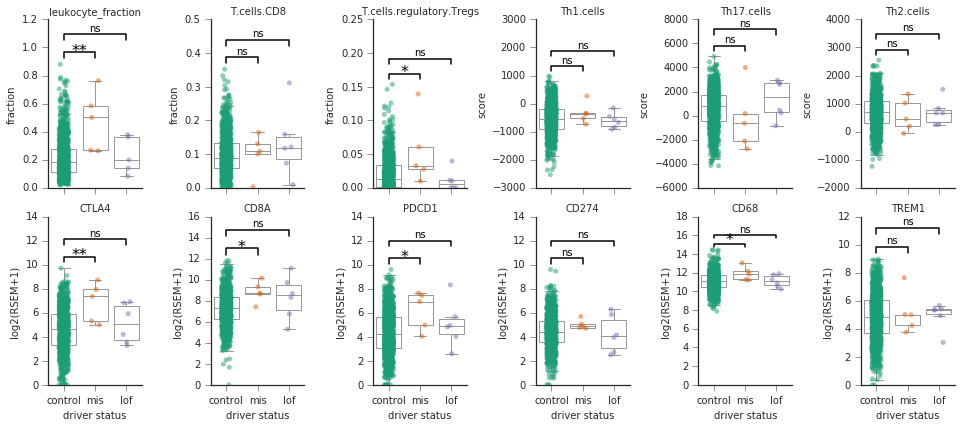

In [12]:
# plot data
myorder = ['control', 'mis', 'lof']
with sns.axes_style('ticks'):
    fg = sns.FacetGrid(plot_df, col='var', col_wrap=6,
                       aspect=.75, sharey=False,)
    fg.map(sns.boxplot, 'driver status', 'log2(RSEM+1)', color='white', order=myorder, fliersize=0)
    fg.map(sns.stripplot, 'driver status', 'log2(RSEM+1)', order=myorder, jitter=.15, palette="Dark2",  alpha=.5)
    fg.map(utils.box_plot_with_significance, 'driver status', 'log2(RSEM+1)', data=plot_df, signif=test_result_df)
    [a.set_ylim(0,) for ix, a in enumerate(fg.axes) if ix<3 or ix>5]
    [a.set_ylabel('log2(RSEM+1)') if ix>2 else a.set_ylabel('fraction')  
     for ix, a in enumerate(fg.axes)]
    [a.set_ylabel('score') 
     for ix, a in enumerate(fg.axes) if ix>2 and ix<6]
    fg.axes[0].set_ylabel('fraction')
    fg.set_titles("{col_name}")
    plt.tight_layout()
    plt.savefig('CHASMplus/figures/figure_S6a.pdf')

### Cervical

In [13]:
# cancer type
ctype = 'CESC'

# cancer types with significant missense mutations in CASP8
ctype_immune_df = panimmune_df[panimmune_df['Study']==ctype].copy()

# figure out which samples contain driver mutations
wt_samps, missense_samps, inactivating_samps = identify_samples(mut_df, gene, ctype)

# label each sample
ctype_immune_df['driver status'] = 'control'
ctype_immune_df.loc[ctype_immune_df['ParticipantBarcode'].isin(missense_samps), 'driver status'] = 'mis'
ctype_immune_df.loc[ctype_immune_df['ParticipantBarcode'].isin(inactivating_samps), 'driver status'] = 'lof'
ctype_immune_df.loc[ctype_immune_df['ParticipantBarcode'].isin(wt_samps), 'driver status'] = 'control'

# prep input
genes = ['CTLA4_RNASeq', 'CD8A_RNASeq', 'PDCD1_RNASeq', 'CD274_RNASeq', 'CD68_RNASeq', 'TREM1_RNASeq']
for g in genes:
    ctype_immune_df[g.split('_')[0]] = np.log2(ctype_immune_df[g]+1)
genes = ['leukocyte_fraction', 'T.cells.CD8', 'T.cells.regulatory.Tregs', 
         'Th1.cells', 'Th17.cells', 'Th2.cells'] + genes
plot_df = pd.melt(ctype_immune_df, 
    id_vars=['ParticipantBarcode', 'Study', 'driver status',], 
    value_vars=[g.split('_RNASeq')[0] #if g!='leukocyte_fraction' else 'leukocyte_fraction' 
                for g in genes ],
    value_name='log2(RSEM+1)',
    var_name='var'
)

# rank test of differences
test_result_df = mannwhitney_test(ctype_immune_df)
test_result_df['cancer type'] = 'CESC'
result_list.append(test_result_df)
test_result_df

,variable,wt vs missense p-value,wt vs lof p-value,mis vs lof p-value,cancer type
0,leukocyte_fraction,0.480061,0.014447,0.185547,CESC
1,T.cells.CD8,0.358174,0.005460,0.116519,CESC
2,T.cells.regulatory.Tregs,0.164099,0.172203,0.500000,CESC
3,Th1.cells,0.232690,0.009139,0.275492,CESC
4,Th17.cells,0.022213,0.297113,0.382797,CESC
5,Th2.cells,0.004706,0.368008,0.018444,CESC
6,CTLA4,0.076354,0.004849,0.500000,CESC
7,CD8A,0.270926,0.002229,0.185547,CESC
8,PDCD1,0.080254,0.003749,0.382797,CESC
9,CD274,0.307361,0.006600,0.116519,CESC


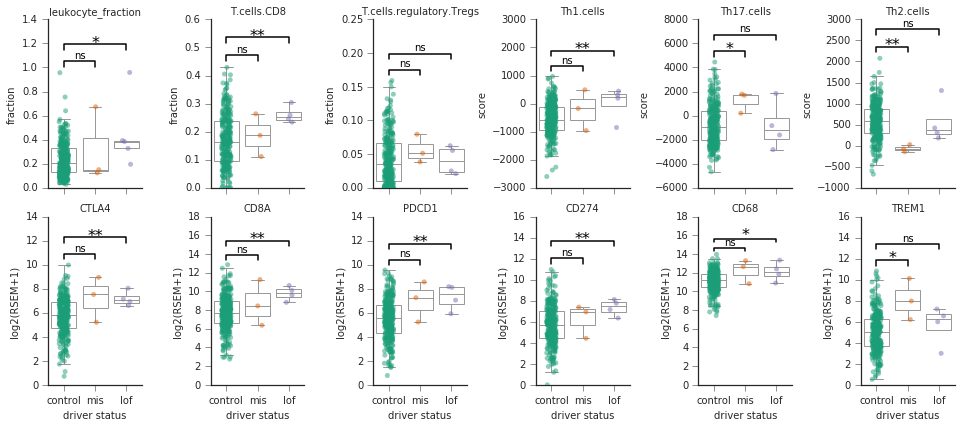

In [14]:
# plot data
myorder = ['control', 'mis', 'lof']
with sns.axes_style('ticks'):
    fg = sns.FacetGrid(plot_df, col='var', col_wrap=6,
                       aspect=.75, sharey=False,)
    fg.map(sns.boxplot, 'driver status', 'log2(RSEM+1)', color='white', order=myorder, fliersize=0)
    fg.map(sns.stripplot, 'driver status', 'log2(RSEM+1)', order=myorder, jitter=.15, palette="Dark2",  alpha=.5)
    fg.map(utils.box_plot_with_significance, 'driver status', 'log2(RSEM+1)', data=plot_df, signif=test_result_df)
    [a.set_ylim(0,) for ix, a in enumerate(fg.axes) if ix<3 or ix>5]
    [a.set_ylabel('log2(RSEM+1)') if ix>2 else a.set_ylabel('fraction')  
     for ix, a in enumerate(fg.axes)]
    [a.set_ylabel('score') 
     for ix, a in enumerate(fg.axes) if ix>2 and ix<6]
    fg.axes[0].set_ylabel('fraction')
    fg.set_titles("{col_name}")
    plt.tight_layout()
    plt.savefig('CHASMplus/figures/figure_S6c.pdf')

### Save supplementary file

In [15]:
supp_table = pd.concat(result_list)
supp_table #.to_csv('CHASMplus/results/supp_table_casp8_immune_correlates.txt', sep='\t', index=False)

,variable,wt vs missense p-value,wt vs lof p-value,mis vs lof p-value,cancer type
0,leukocyte_fraction,0.000067,0.000248,0.347542,HNSC
1,T.cells.CD8,0.000200,0.000276,0.150290,HNSC
2,T.cells.regulatory.Tregs,0.306188,0.309716,0.179689,HNSC
3,Th1.cells,0.000005,0.005064,0.013171,HNSC
4,Th17.cells,0.073618,0.180456,0.325538,HNSC
5,Th2.cells,0.352668,0.078705,0.213604,HNSC
6,CTLA4,0.001806,0.026692,0.097402,HNSC
7,CD8A,0.000026,0.003328,0.032941,HNSC
8,PDCD1,0.000066,0.017043,0.022749,HNSC
9,CD274,0.000024,0.000219,0.174975,HNSC
